# 基于深度学习与计算机视觉的授予手语识别项目

In [2]:
import mediapipe as mp
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import pandas as pd
from cv2 import cvtColor, COLOR_RGB2BGR, COLOR_BGR2RGB

### 第一步：导入数据标签
在trainset01这个文件之中，存放的是视频文件的文件名以及一个int数字，估计是代表不同手语类别的分类数据

In [3]:
os.chdir(r'F:\dataset\TrainSet01')

In [4]:
labels = pd.read_csv(r"F:\dataset\train_labels.csv")

In [5]:
labels['label'] = labels['label'].astype(np.int32)
labels.head()

,filename,label
0,signer0_sample1,41
1,signer0_sample2,104
2,signer0_sample3,205
3,signer0_sample4,26
4,signer0_sample5,191


In [6]:
labels.index = labels.filename

In [7]:
labels = labels.drop(['filename'], axis=1)
labels.head()

,label
filename,
signer0_sample1,41
signer0_sample2,104
signer0_sample3,205
signer0_sample4,26
signer0_sample5,191


In [8]:
def get_label_by_filename(filename):
    return labels.loc[filename, 'label']

### 2. 导入holistic
holistic是mediapipe提供的用于进行身体姿态识别的类。
在这一部分之中，先后进行了创建holistic对象，编辑身体动作标记、样式的函数

In [9]:
holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils

In [10]:
def pltLandMarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, holistic.FACEMESH_TESSELATION)
    mp_drawing.draw_landmarks(image, results.pose_landmarks, holistic.POSE_CONNECTIONS)
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, holistic.HAND_CONNECTIONS)
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, holistic.HAND_CONNECTIONS)

In [11]:
def styledLandMarks(image, results):
    """
    该函数用于设置身体姿态标记点的样式
    :param image: 输入的图片
    :param results: 经过holistic处理的包含身体姿态识别信息的数据
    :return: None
    """
    mp_drawing.draw_landmarks(
        image,
        results.face_landmarks,
        holistic.FACEMESH_TESSELATION,
        mp_drawing.DrawingSpec(
            color=(90, 100, 10),
            thickness=1,
            circle_radius=1
        ),
        mp_drawing.DrawingSpec(
            color=(80, 256, 121),
            thickness=1,
            circle_radius=1
        )
    )
    mp_drawing.draw_landmarks(
        image,
        results.pose_landmarks,
        holistic.POSE_CONNECTIONS,
        mp_drawing.DrawingSpec(
            color=(80, 22, 10),
            thickness=2,
            circle_radius=2
        ),
        mp_drawing.DrawingSpec(
            color=(80, 44, 110),
            thickness=2,
            circle_radius=2
        )
    )
    mp_drawing.draw_landmarks(
        image,
        results.pose_landmarks,
        holistic.POSE_CONNECTIONS,
        mp_drawing.DrawingSpec(
            color=(121, 22, 76),
            thickness=2,
            circle_radius=4
        ),
        mp_drawing.DrawingSpec(
            color=(121, 44, 250),
            thickness=2,
            circle_radius=2
        )
    )
    mp_drawing.draw_landmarks(
        image,
        results.pose_landmarks,
        holistic.POSE_CONNECTIONS,
        mp_drawing.DrawingSpec(
            color=(245, 117, 77),
            thickness=2,
            circle_radius=4
        ),
        mp_drawing.DrawingSpec(
            color=(245, 66, 230),
            thickness=2,
            circle_radius=2
        )
    )

**身体，面部，左手，右手的姿态转换为`np.array`存储到列表之中**
+ 左手右手：21*3
+ 面部：468*3
+ 身体:33*4      除了$(x,y,z)$,还有`visibility`属性

In [12]:
fileName = r"signer0_sample1_color.mp4"
label = fileName.split('_')[0] + '_' + fileName.split('_')[1]
label

'signer0_sample1'

In [13]:
def getFileList(path):
    file_list = os.listdir(path)  # 获取所有文件名
    file_list = [i for i in file_list if 'depth' not in i]  # 这里不使用深度数据
    return file_list

In [14]:
def getLabel(file_list):
    """
    返回索引名，以方便查找对应的分类
    :param args:
    :return:
    """
    label_list = []
    for file in file_list:
        labels.append(get_label_by_filename(file))
    return label_list

In [ ]:
def video_to_frames(video_path):
    times = 0

    # 提取视频的频率，每1帧提取一个
    frame_frequency = 1

    camera = cv2.VideoCapture(video_path)
    results_list = []
    while True:
        times = times + 1
        res, image = camera.read()
        with holistic.Holistic(min_tracking_confidence=0.5, min_detection_confidence=0.5) as mp_holistic:
            if res:
                results = mp_holistic.process(image)
                results_list.append(results)

        if not res:
            print('no res,no image')
            break

    print('图片提取结束')
    camera.release()

    return results_list

In [104]:
def data_process(results_list):
        pose = np.array([[res.x, res.y, res.z, res.visibility] for res in
                         results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(132)
        face = np.array([[res.x, res.y, res.z] for res in
                 results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(1404)
        lh = np.array([[res.x, res.y, res.z] for res in
               results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21 * 3)
        rh = np.array([[res.x, res.y, res.z] for res in
               results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21 * 3)
        return np.concatenate([pose,face,lh,rh])

In [107]:
data_process(results_list[10])

array([ 0.58324182,  0.41433343, -0.41488135, ...,  0.48539582,
        0.89360631, -0.02904895])

In [ ]:
file_paths = []  #该列表将存储所有完整的文件路径
for root, directories, files in os.walk(r'F:\dataset\TrainSet01'):
    for filename in files:
        # 连接两个字符串以形成完整的文件路径。
        filepath = os.path.join(root, filename)
        file_paths.append(filepath)
file_paths

In [86]:
res1 = results_list[1]
res1

mediapipe.python.solution_base.SolutionOutputs

In [87]:
res1.face_landmarks

landmark {
  x: 0.5820525884628296
  y: 0.436359167098999
  z: -0.013988140970468521
}
landmark {
  x: 0.5832337141036987
  y: 0.42053836584091187
  z: -0.023139961063861847
}
landmark {
  x: 0.5824092030525208
  y: 0.42603304982185364
  z: -0.012871745973825455
}
landmark {
  x: 0.5790584683418274
  y: 0.40697669982910156
  z: -0.016517065465450287
}
landmark {
  x: 0.5833167433738708
  y: 0.4159252643585205
  z: -0.02431156113743782
}
landmark {
  x: 0.5831150412559509
  y: 0.4104470908641815
  z: -0.022138342261314392
}
landmark {
  x: 0.5821945071220398
  y: 0.39774903655052185
  z: -0.009369865991175175
}
landmark {
  x: 0.5489146113395691
  y: 0.3990462124347687
  z: 0.005737110506743193
}
landmark {
  x: 0.5817605257034302
  y: 0.3876548409461975
  z: -0.005636472254991531
}
landmark {
  x: 0.5816863775253296
  y: 0.3814600110054016
  z: -0.0060401372611522675
}
landmark {
  x: 0.5809052586555481
  y: 0.35805028676986694
  z: 0.0005911971675232053
}
landmark {
  x: 0.58197939395

In [100]:
face = np.array(
    [[res.x, res.y, res.z] for res in res1.face_landmarks.landmark]).flatten() if res1.face_landmarks else np.zeros(
    1404)

In [101]:
face

array([ 0.58205259,  0.43635917, -0.01398814, ...,  0.61467671,
        0.39437732,  0.01031178])

In [70]:
video = cv2.VideoCapture(r'signer0_sample1_color.mp4')
arr = []
with holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as mp_holistic:
    # video.open(r'signer0_sample1_color.mp4')
    # video.open()
    while video.isOpened():
        ret, frame = video.read()
        # arr.append(frame)
        image = cvtColor(frame, COLOR_BGR2RGB)
        results = mp_holistic.process(image)
        # arr.append(image)
        arr.append(results)
        # pltLandMarks(image, results)
        # styledLandMarks(image,results)
        # cv2.imshow('Opencv Feed', image)
        # if cv2.waitKey(10) & 0xFF == ord('q'):
        #     break
        video.release()
        cv2.destroyAllWindows()

In [71]:
len(arr)

1

In [72]:
arr[-1].left_hand_landmarks

landmark {
  x: 0.7111101746559143
  y: 0.8152901530265808
  z: 4.0558475689067564e-08
}
landmark {
  x: 0.6846517324447632
  y: 0.8228068351745605
  z: -0.013350261375308037
}
landmark {
  x: 0.6665801405906677
  y: 0.8403066396713257
  z: -0.021757744252681732
}
landmark {
  x: 0.6599130034446716
  y: 0.8607985377311707
  z: -0.027349011972546577
}
landmark {
  x: 0.6570481657981873
  y: 0.8774974942207336
  z: -0.03279770165681839
}
landmark {
  x: 0.6911984086036682
  y: 0.8508501052856445
  z: -0.029240399599075317
}
landmark {
  x: 0.696031391620636
  y: 0.8760719895362854
  z: -0.038716286420822144
}
landmark {
  x: 0.6990865468978882
  y: 0.8917929530143738
  z: -0.04289533197879791
}
landmark {
  x: 0.7019279599189758
  y: 0.9057327508926392
  z: -0.04554540663957596
}
landmark {
  x: 0.7099168300628662
  y: 0.8539390563964844
  z: -0.026328355073928833
}
landmark {
  x: 0.7150018811225891
  y: 0.8798163533210754
  z: -0.03454720228910446
}
landmark {
  x: 0.7174208760261536
 

In [57]:
li = [i for i in results.left_hand_landmarks.landmark]
li  # 该数据是全过程的还是最后一帧的？

[x: 0.7111101746559143
 y: 0.8152901530265808
 z: 4.0558475689067564e-08,
 x: 0.6846517324447632
 y: 0.8228068351745605
 z: -0.013350261375308037,
 x: 0.6665801405906677
 y: 0.8403066396713257
 z: -0.021757744252681732,
 x: 0.6599130034446716
 y: 0.8607985377311707
 z: -0.027349011972546577,
 x: 0.6570481657981873
 y: 0.8774974942207336
 z: -0.03279770165681839,
 x: 0.6911984086036682
 y: 0.8508501052856445
 z: -0.029240399599075317,
 x: 0.696031391620636
 y: 0.8760719895362854
 z: -0.038716286420822144,
 x: 0.6990865468978882
 y: 0.8917929530143738
 z: -0.04289533197879791,
 x: 0.7019279599189758
 y: 0.9057327508926392
 z: -0.04554540663957596,
 x: 0.7099168300628662
 y: 0.8539390563964844
 z: -0.026328355073928833,
 x: 0.7150018811225891
 y: 0.8798163533210754
 z: -0.03454720228910446,
 x: 0.7174208760261536
 y: 0.8974273800849915
 z: -0.0374150276184082,
 x: 0.7190181016921997
 y: 0.9121895432472229
 z: -0.04015034809708595,
 x: 0.7239631414413452
 y: 0.8556843996047974
 z: -0.02334

In [58]:
len(li)

21

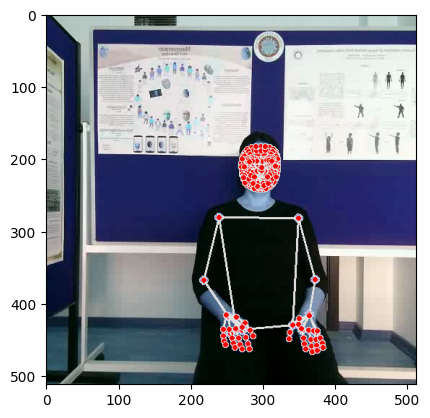

In [66]:
pltLandMarks(image, results)
plt.imshow(cv2.cvtColor(image, COLOR_BGR2RGB))

### 第三步：数据预处理
将身体姿势的三位做坐标全部转换为1维的有序的向量作为神经网络的输入。之后构建LSTM深度学习网络。
